In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.models.alexnet import AlexNet_Weights
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

/Users/nikoletaulama/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Resize the images

In [4]:
def resize_transformation(img):
    resize = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
    i = resize(img)
    return i

Import datasets

In [5]:
train_dataset = ImageFolder(root="../train", transform=resize_transformation)
test_dataset = ImageFolder(root="../test", transform=resize_transformation)

Split the training set in 85% for actual training set and 15% to be used as validation set

In [6]:
train_size = int(0.85 * len(train_dataset))
validation_size = len(train_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(
    train_dataset, [train_size, validation_size]
)

In [7]:
class Augmentation:

    def __init__(self, ds):
        self.ds = ds
        self.transformation = transforms.RandomHorizontalFlip(1)

    def __getitem__(self, index):
        img, label = self.ds[index]

        if self.transformation:
            img = self.transformation(img)

        return img, label

    def __len__(self):
        return len(self.ds)

Minibatches of size 32; 
Apply augmentation

In [8]:
batch_size = 32
augmented_training_set = Augmentation(training_set)
concatenated_dataset = torch.utils.data.ConcatDataset(
    [training_set, augmented_training_set]
)
augmented_train_loader = DataLoader(
    concatenated_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

validation_loader = DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, pin_memory=True
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Network layout

In [9]:
class CNN(nn.Module):  

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=7, padding=3)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.25)  

        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)  
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu_fc1(x)  
        x = self.fc2(x)
        return x

AlexNet

In [10]:
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

In [11]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 15)

for param in model.classifier[6].parameters():
    param.requires_grad = True

Employ the stochastic gradient descent with momentum optimization algorithm

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Training and Validation

In [13]:
epochs = 30

best_validation_loss = np.inf
train_losses = []
validation_losses = []
validation_accuracies = []
train_accuracies = []
for epoch in range(epochs):
    print("EPOCH {}:".format(epoch + 1))

    model.train(True)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(augmented_train_loader):

        input, labels = data  

        outputs = model(input)  

        loss = loss_function(outputs, labels)  
        running_loss += (
            loss.item()
        )  

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

    train_loss = running_loss / (i + 1)  
    train_accuracy = correct_predictions / total_samples

    running_validation_loss = 0.0

    model.eval()

    with torch.no_grad():  
        correct = 0
        total = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_function(voutputs, vlabels)
            running_validation_loss += vloss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = running_validation_loss / (i + 1)  
    validation_acc = 100 * correct / total

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_acc)
    train_accuracies.append(train_accuracy)

    print("LOSS train {} validation {}".format(train_loss, validation_loss))
    print(f"LOSS train: {train_loss} validation: {validation_loss} | validation_accuracy: {validation_acc}% ")

    if validation_loss < best_validation_loss:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        best_validation_loss = validation_loss
        model_path = "model_{}_{}".format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)

model.load_state_dict(torch.load(model_path))

EPOCH 1:
LOSS train 1.180028859525919 validation 0.6774354577064514
LOSS train: 1.180028859525919 validation: 0.6774354577064514 | validation_accuracy: 81.81818181818181% 
EPOCH 2:
LOSS train 0.6601320840418339 validation 0.5722751617431641
LOSS train: 0.6601320840418339 validation: 0.5722751617431641 | validation_accuracy: 86.36363636363636% 
EPOCH 3:
LOSS train 0.579015887901187 validation 0.5706918835639954
LOSS train: 0.579015887901187 validation: 0.5706918835639954 | validation_accuracy: 77.27272727272727% 
EPOCH 4:
LOSS train 0.5235531877726316 validation 0.615630030632019
LOSS train: 0.5235531877726316 validation: 0.615630030632019 | validation_accuracy: 77.27272727272727% 
EPOCH 5:
LOSS train 0.4780798401683569 validation 0.6765011548995972
LOSS train: 0.4780798401683569 validation: 0.6765011548995972 | validation_accuracy: 72.72727272727273% 
EPOCH 6:
LOSS train 0.452810469456017 validation 0.49045297503471375
LOSS train: 0.452810469456017 validation: 0.49045297503471375 | val

<All keys matched successfully>

Training and Validation Metrics

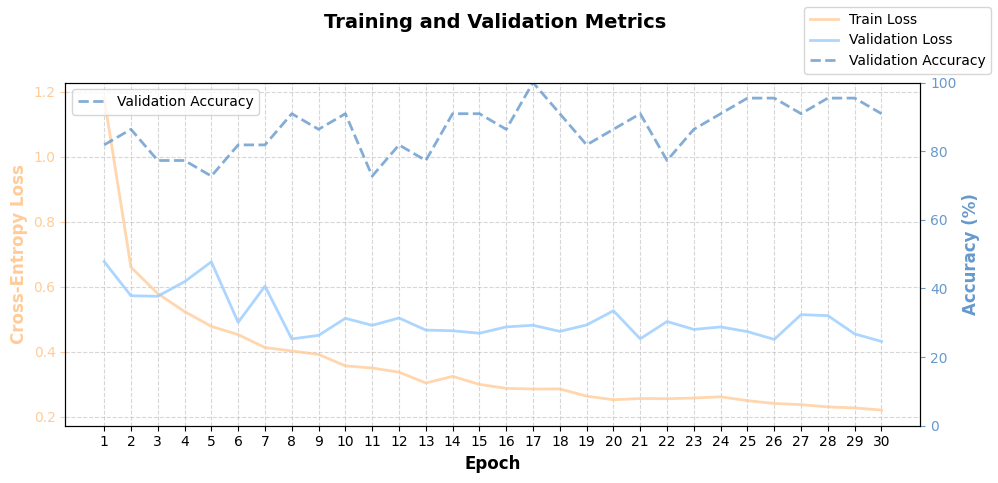

In [14]:
pastel_orange = (1.0, 0.8, 0.6)
pastel_blue = (0.6, 0.8, 1.0, 1.0)
pastel_dark_blue = (0.4, 0.6, 0.8, 1.0)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(train_losses, color=pastel_orange, linewidth=2, label="Train Loss", alpha=0.8)
validation_losses_np = torch.stack(validation_losses).cpu().numpy()
ax1.plot(
    validation_losses_np,
    color=pastel_blue,
    linewidth=2,
    label="Validation Loss",
    alpha=0.8,
)

ax1.set_xlabel("Epoch", fontsize=12, fontweight="bold")
ax1.set_ylabel(
    "Cross-Entropy Loss", fontsize=12, fontweight="bold", color=pastel_orange
)
ax1.tick_params(axis="y", colors=pastel_orange)
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.set_xticks(range(len(train_losses)))
ax1.set_xticklabels(range(1, len(train_losses) + 1))
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

ax2.plot(
    validation_accuracies,
    color=pastel_dark_blue,
    linestyle="--",
    linewidth=2,
    label="Validation Accuracy",
    alpha=0.8,
)

ax2.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold", color=pastel_dark_blue)
ax2.tick_params(axis="y", colors=pastel_dark_blue)
ax2.set_ylim(0, 100)
ax2.legend(loc="upper left", fontsize=10)

fig.legend(loc="upper right", fontsize=10)
fig.set_size_inches(10, 5)

fig.suptitle("Training and Validation Metrics", fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Test and Accuracy

In [15]:
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted) 
        y_true.extend(labels)  

print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

Accuracy of the network on the test images: 83.28%


Confusion Matrix

<Axes: >

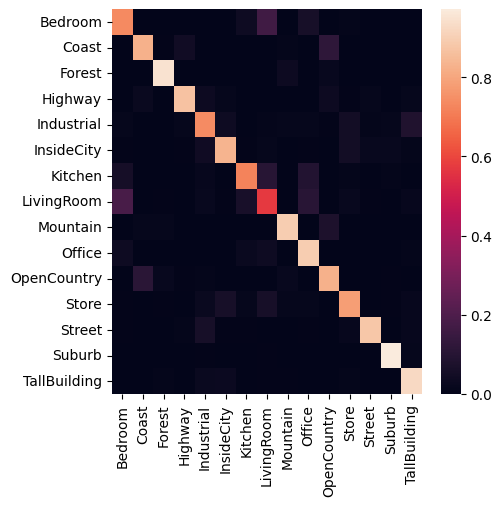

In [16]:
classes = test_dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
    index=[i for i in classes],
    columns=[i for i in classes],
)
plt.figure(figsize=(5, 5))
sn.heatmap(df_cm)